## makemore 3 

__Batch Normalization__
[Batch Normalization Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

The research paper titled "Deep Residual Learning for Image Recognition" presents a breakthrough innovation in training deep neural networks for image recognition tasks. This innovation involves using very deep neural networks with "shortcut connections" (also known as "skip connections" or "identity mappings") to overcome the problem of vanishing gradients. 

Simply put, the problem of vanishing gradients arises when the gradients of the loss function with respect to the weights become very small as they are propagated backwards through multiple layers of a deep neural network. This problem makes it difficult to train neural networks with many layers, as the weights of the early layers do not get updated effectively. One common solution to this problem is to use a technique called "batch normalization" that normalizes the inputs to each layer. However, this technique has its own limitations and does not always work well in practice.

The innovation presented in this paper involves using "shortcut connections" to enable the gradients to propagate more easily through the network. These connections allow the input of a layer to be added to the output of another layer further down the network, creating a "residual" of the input that can bypass one or more layers. The key insight behind this technique is that if the skipped layers can approximate an identity function, then the network can be more easily optimized to learn the desired mapping between the input and output.

The authors demonstrate the effectiveness of their approach on the challenging ImageNet dataset, where they achieve state-of-the-art results using very deep neural networks with up to 152 layers. They also show that their approach is effective for a wide range of other image recognition tasks, including object detection and semantic segmentation.

Overall, the paper provides a significant contribution to the field of deep learning by providing a new approach to training very deep neural networks that can optimize the learning process more effectively than previous techniques. This innovation has many potential applications in computer vision and other fields that rely on deep neural networks for learning complex mappings between inputs and outputs.

In [38]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# read in all of the data
words = open('data/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [40]:
len(words)

32033

In [41]:
# build the vocab of characters and mappings to and from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [42]:
# build the dataset
block_size = 3 # this is the length of the sequences we will use for training

def build_dataset(words):

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift the context by one character
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1]) # training set 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # dev set 10%
Xte, Yte = build_dataset(words[n2:]) # test set 10%



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [43]:
# MLP revisited 

n_embd = 10 # embedding dimension
n_hidden = 200 # hidden dimension

g = torch.Generator().manual_seed(2147483647) # this is for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # the embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  * (5/3) * ((n_embd * block_size) ** 0.5)# the first weight matrix
# b1 = torch.randn((n_hidden), generator=g) * 0.01 # the first bias vector
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # the second weight matrix
b2 = torch.randn((vocab_size), generator=g) * 0 # the second bias vector

#batchNorm parameters
bngain = torch.ones((1, n_hidden)) # gain parameter
bnbias = torch.zeros((1, n_hidden)) # bias parameter
bnmean_running = torch.zeros((1, n_hidden)) # running mean
bnstd_running = torch.ones((1, n_hidden)) # running std

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total 
for p in parameters:
    p.requires_grad = True # we need gradients w.r.t. all parameters


12097


In [45]:


# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  



      0/ 200000: 3.3002
  10000/ 200000: 2.3523
  20000/ 200000: 2.0749
  30000/ 200000: 2.1108
  40000/ 200000: 2.2084
  50000/ 200000: 2.7371
  60000/ 200000: 2.2555
  70000/ 200000: 2.7734
  80000/ 200000: 2.6308
  90000/ 200000: 2.2677
 100000/ 200000: 2.0917
 110000/ 200000: 1.9005
 120000/ 200000: 1.9174
 130000/ 200000: 2.4031
 140000/ 200000: 2.6117
 150000/ 200000: 2.4558
 160000/ 200000: 2.3112
 170000/ 200000: 2.2932
 180000/ 200000: 2.2847
 190000/ 200000: 2.3320


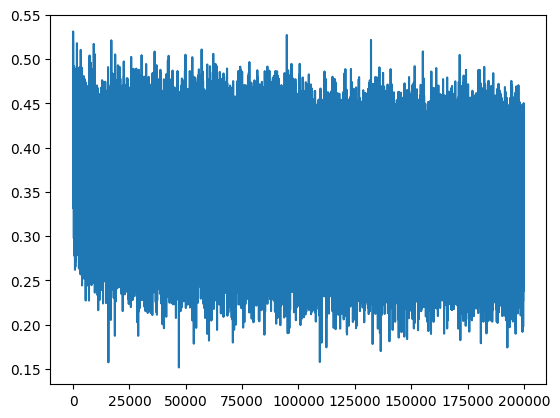

In [46]:
plt.plot(lossi)

In [ ]:
# advice for karpathy - avoid batchnorm layer where possible!!

# getting more into how to incorporate our code more into pytorch

